In [1]:
%matplotlib inline
import numpy as np
import numpy, scipy, matplotlib.pyplot as plt, librosa, IPython.display as ipd
import librosa.display
import math, scipy.signal
import mir_eval

# Complex Domain Novelty Function

This project is an implementation of the
Complex Domain Novelty Function, or the Complex Domain Onset Detection Function

Refer to the literature *Fundamentals of Music Processing* (Meinard Muller, 2015)
for detailed explanations.

In [2]:
# example of drum 1 (simple)
# filename = 'music/classic_rock_beat.wav'

# example of drum 2 (fast)
# GYARI - 何でも言うことを聞いてくれるアカネチャン
# filename = 'music/akane.wav'

# example of piano
# Stefan Balke's record
# filename = 'music/sir_duke_piano_fast.mp3'

# example of mixed piano music
# Taku Inoue - 夜明けまであと3秒
filename = 'music/yoake.wav'

# example of complicated (barely acceptable)
# The Green Orbs - The Farmer In The Dell
# filename = 'music/example.wav'

# example of complicated (unacceptable)
# GYARI - 何でも言うことを聞いてくれるアカネチャン
# filename = 'music/akane2.wav'

# SAMPLE_RATE = 44100
STFT_WINDOW = 2048
STFT_HOP = 512
# important
AVERAGE_WINDOW = 9

# Do log 1p scale compression on the stft before calculation of novelty
LOG_COMPRESS = False

## load music file

In [3]:
use_file_example = True

if use_file_example:
    print(f'loading file {filename}')
    x, sr = librosa.load(filename, sr=None) # we use the native sample rate
else:
    sr = 22050


    def generate_tone(midi):
        T = 0.5
        t = numpy.linspace(0, T, int(T * sr), endpoint=False)
        f = librosa.midi_to_hz(midi)
        return numpy.sin(2 * numpy.pi * f * t)


    x = numpy.concatenate([generate_tone(midi) for midi in [48, 52, 55, 60, 64, 67, 72, 76, 79, 84]])

print(f'Sample Rate: {sr}')
print(f'{x.shape}')
print(f'Length of the audio: {float(x.size) / sr} sec')
ipd.Audio(x, rate=sr)

loading file music/yoake.wav
Sample Rate: 48000
(529090,)
Length of the audio: 11.022708333333334 sec


## calculate the STFT


In [4]:
print('Short Time Fourier Transform Info:')
print(f'Window Size: {float(STFT_WINDOW) / sr}')
print(f'Hop Size: {float(STFT_HOP) / sr}')
stft = librosa.stft(x, n_fft=STFT_WINDOW, hop_length=STFT_HOP)

# only for debug
# stft = numpy.array([
#     [1 + 1j, -1 + 1j, -1 - 1j, 1 - 1j, 1 + 1j, 0, 0, -1 + 1j, -1 - 1j, 1 - 1j],
#     [1 + 1j, -1 + 1j, -1 - 1j, 1 - 1j, 1 + 1j, 0, 0, -1 + 1j, -1 - 1j, 1 - 1j]
# ])

Short Time Fourier Transform Info:
Window Size: 0.042666666666666665
Hop Size: 0.010666666666666666


## Spectrum of the STFT

In [5]:
# stft = numpy.array(
#         [[1+1j,2+2j,3+3j,4+4j,5+5j,6+6j],
#         [4+4j,5+5j,9+9j,8+8j,7+7j,9+9j]]
# )
print('(freq bins, frames)')
print(stft.shape)

n = stft.shape[1]
amplitude = abs(stft)

(freq bins, frames)
(1025, 1034)


## Raw Spectrogram (Amplitude)

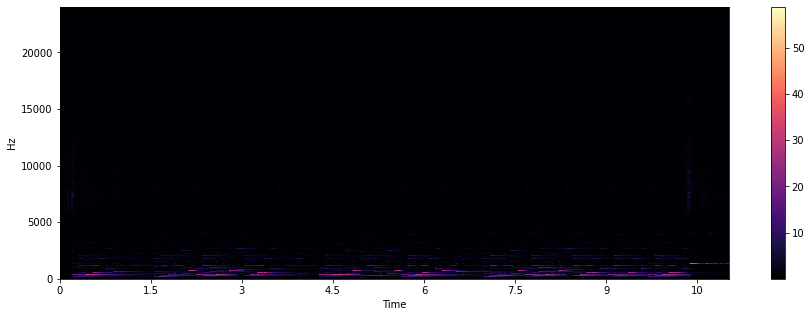

In [6]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(amplitude, sr=sr, hop_length=STFT_HOP, x_axis='time', y_axis='linear')
plt.colorbar()

## Logarithm Spectrogram

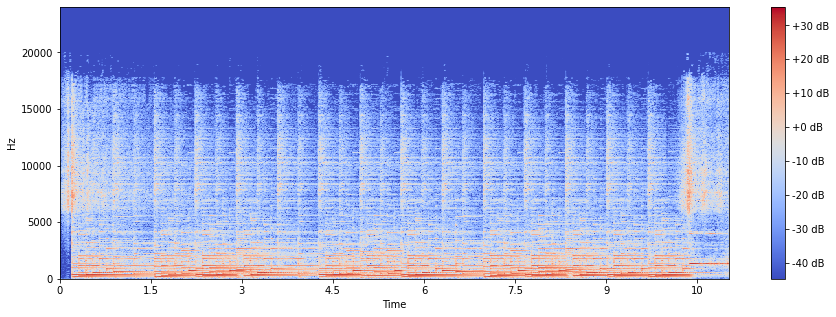

In [7]:
spectrum = librosa.amplitude_to_db(amplitude)
plt.figure(figsize=(15, 5))
librosa.display.specshow(spectrum, sr=sr, hop_length=STFT_HOP, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')

## Calculate the amplitude and the phase

In [8]:
if LOG_COMPRESS:
    stft = numpy.log1p(stft)
amplitude = abs(stft)
phase = numpy.angle(stft)
phase_diff = numpy.diff(phase)
# note that phase_diff[n] = phase[n+1] - phase[n]
predict_stft = numpy.zeros_like(stft, dtype=numpy.complex_)

## Prediction of STFT frames & magnitude difference

In [9]:
# . . . . . . . .
# ^ ^difference calculated
#     ^ predicted

for i in range(2, n):
    real = numpy.multiply(amplitude[:, i - 1], numpy.cos(numpy.add(phase[:, i - 1], phase_diff[:, i - 2])))
    imag = numpy.multiply(amplitude[:, i - 1], numpy.sin(numpy.add(phase[:, i - 1], phase_diff[:, i - 2])))
    predict_stft[:, i] = numpy.vectorize(complex)(real, imag)

diff_stft_prediction = numpy.subtract(stft, predict_stft)
diff_stft_prediction[:, 0:2] = 0  # set #0 and #1 to be 0 (not calculated)

## Magnitude Difference
Calculate difference in EACH frequency bin.

Given that the diff is complex, we calculate the abs value,
but half-wave rectify for those in which actual amplitude is smaller than expected

### Onset Strength
Difference of those in which the expected is smaller than actual magnitude

### Offset Strength
Vice Versa

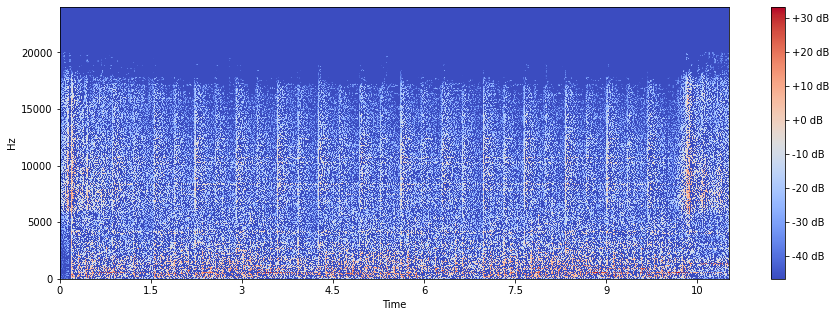

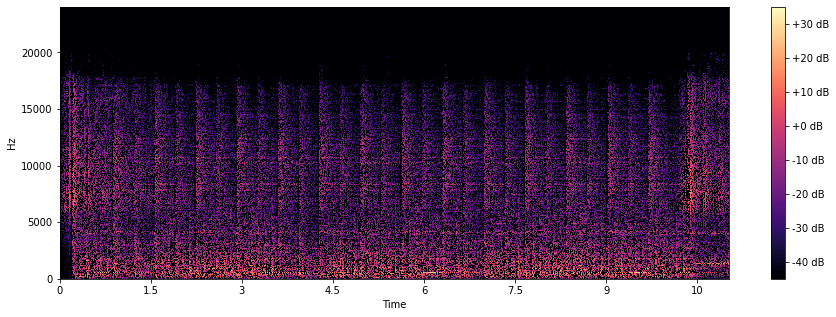

In [10]:
onset_strength = numpy.zeros_like(diff_stft_prediction, dtype=float)
offset_strength = numpy.zeros_like(diff_stft_prediction, dtype=float)
# half-wave rectify
for i in range(stft.shape[1]):  # frames
    for j in range(stft.shape[0]):  # freq bins
        if abs(stft[j, i]) > abs(predict_stft[j, i]):
            onset_strength[j, i] = abs(diff_stft_prediction[j, i])
            offset_strength[j, i] = 0
        elif abs(stft[j, i]) < abs(predict_stft[j, i]):
            onset_strength[j, i] = 0
            offset_strength[j, i] = abs(diff_stft_prediction[j, i])
        else:
            onset_strength[j, i] = offset_strength[j, i] = abs(diff_stft_prediction[j, i])

plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.amplitude_to_db(onset_strength), sr=sr, hop_length=STFT_HOP, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.show()

plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.amplitude_to_db(offset_strength), sr=sr, hop_length=STFT_HOP, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')


## Sum up the rectified frequency bins' difference

We use two approach here,
one is the simple sum of all onset strength in each frequency bins.
The other is we take the sum of squared strength of each frequency bins, and take its square root.

In [11]:
cd_novelty = numpy.zeros(n)
cd_novelty_sq_each = numpy.zeros(n)
for i in range(0, n):
    cd_novelty[i] = numpy.sum(onset_strength[:, i])
    cd_novelty_sq_each[i] = math.sqrt(numpy.sum(numpy.square(onset_strength[:, i])))
cd_novelty_squared = numpy.square(cd_novelty)
# cd_novelty = numpy.log1p(cd_novelty)

The plot looks like this

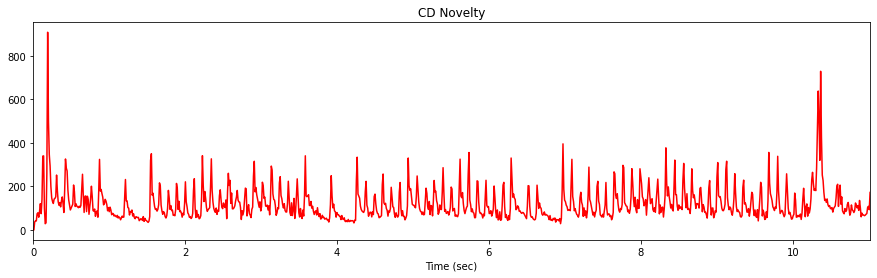

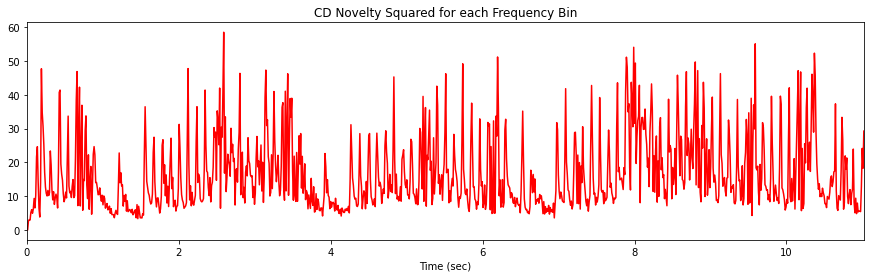

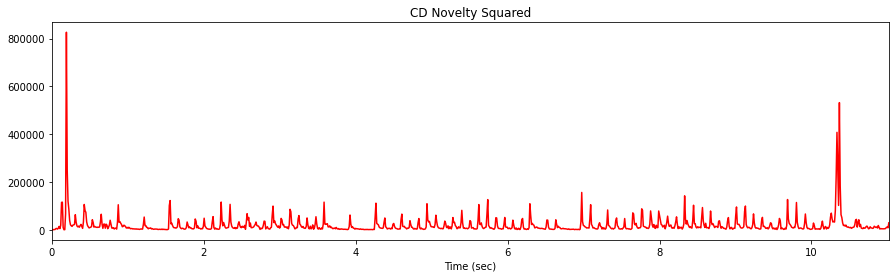

In [12]:
frames = numpy.arange(len(cd_novelty))
time_axis = librosa.frames_to_time(frames, sr=sr)
plt.figure(figsize=(15, 4))
plt.xlim(0, time_axis.max())
plt.xlabel('Time (sec)')
plt.title('CD Novelty')
plt.plot(time_axis, cd_novelty, 'r-')
plt.show()

plt.figure(figsize=(15, 4))
plt.xlim(0, time_axis.max())
plt.xlabel('Time (sec)')
plt.title('CD Novelty Squared for each Frequency Bin')
plt.plot(time_axis, cd_novelty_sq_each, 'r-')
plt.show()

plt.figure(figsize=(15, 4))
plt.xlim(0, time_axis.max())
plt.xlabel('Time (sec)')
plt.title('CD Novelty Squared')
plt.plot(time_axis, cd_novelty_squared, 'r-')
plt.show()

In [13]:
# specify which we want to use later

novelty_function = cd_novelty

## Moving average
This is important for peak-picking. You can see how different tracks need different M value for averaging.

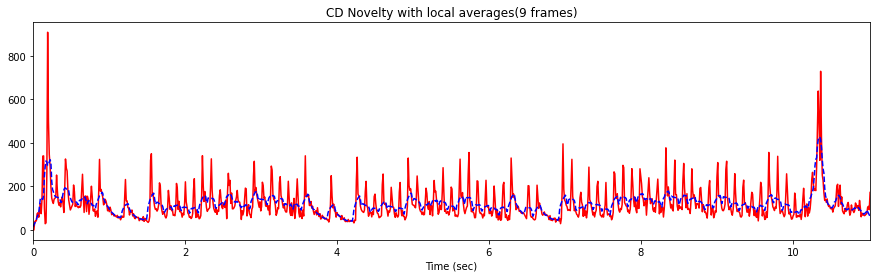

In [14]:
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'same') / float(n)

novelty_average = moving_average(novelty_function, AVERAGE_WINDOW)

frames = numpy.arange(len(novelty_function))
time_axis = librosa.frames_to_time(frames, sr=sr)
plt.figure(figsize=(15, 4))
plt.xlim(0, time_axis.max())
plt.xlabel('Time (sec)')
plt.title(f'CD Novelty with local averages({AVERAGE_WINDOW} frames)')
plt.plot(time_axis, novelty_function, 'r-', time_axis, novelty_average, 'b--')

Now we subtract the CD novelty with local average

In [15]:
novelty_function = numpy.subtract(novelty_function, novelty_average)
novelty_function = numpy.max([novelty_function, numpy.zeros_like(novelty_function)], axis=0)

## Plots

Here we compare with the `librosa.onset.onset_strength()`, which uses
Spectral Flux to calculate onset strength

Peak above the average value are picked.

Text(0.5, 1.0, 'Spectral Flux ODF')

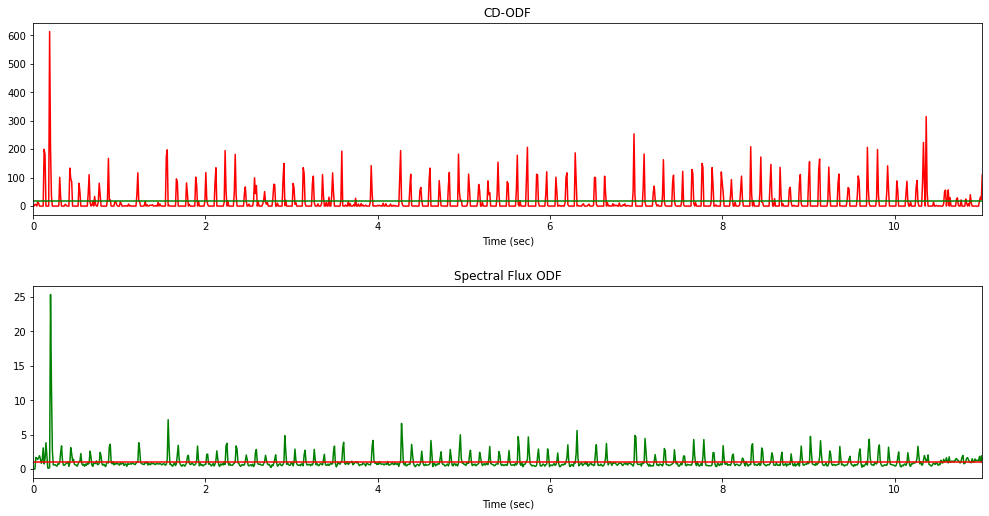

In [16]:
# extra comparison with librosa
spectral_novelty = librosa.onset.onset_strength(x, sr=sr)

fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))
fig.tight_layout(pad=5)
ax1.plot(time_axis, novelty_function, 'r-')
ax1.axhline(y=numpy.average(novelty_function), c='green')
ax1.set_xlim(0, time_axis.max())
ax1.set_xlabel('Time (sec)')
ax1.set_title('CD-ODF')
ax2.plot(time_axis, spectral_novelty, 'g-')
ax2.axhline(y=numpy.average(spectral_novelty), c='red')
ax2.set_xlim(0, time_axis.max())
ax2.set_xlabel('Time (sec)')
ax2.set_title('Spectral Flux ODF')


## Audio Evaluation

Compare CD Novelty to Spectral Flux Novelty

In [17]:
# CD Novelty
peaks = scipy.signal.find_peaks(novelty_function, height=numpy.average(novelty_function))
onset_times = librosa.frames_to_time(peaks[0], sr=sr)
x_with_clicks = mir_eval.sonify.clicks(onset_times, sr, length=len(x))
ipd.Audio(x + x_with_clicks, rate=sr)

In [18]:
# Spectral Flux Novelty
peaks = scipy.signal.find_peaks(spectral_novelty, height=numpy.average(spectral_novelty))
onset_times = librosa.frames_to_time(peaks[0], sr=sr)
x_with_clicks = mir_eval.sonify.clicks(onset_times, sr, length=len(x))
ipd.Audio(x + x_with_clicks, rate=sr)
